In [1]:
import pandas as pd
import numpy as np
import pickle

import requests
from bs4 import BeautifulSoup

from collections import defaultdict

from matplotlib import pyplot as plt
import seaborn as sns

# Loading data

In [7]:
df_listings = pd.read_csv("/Users/xupingwang/Desktop/project_5/airbnb/listings.csv")
# df_listings_2 = pd.read_csv("/Users/xupingwang/Desktop/project_5/airbnb/listings-2.csv")
df_stations = pd.read_csv("/Users/xupingwang/Desktop/project_5/airbnb/CTA_-_System_Information_-_List_of__L__Stops.csv")

/anaconda3/envs/metis/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (43,61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Webscrape median income by ZIP code

In [70]:
# download with census api if data can be found

website_url = requests.get('http://zipatlas.com/us/il/chicago/zip-code-comparison/median-household-income.htm').text
soup = BeautifulSoup(website_url,'lxml')
# print(soup.prettify())

My_table = soup.find('table')
header = My_table.findAll('td', {'class': "report_header"})
content = My_table.findAll('td', {'class': "report_data"})

col= [x.text.lower() for x in header]
data = [x.text for x in content]

df_income = pd.DataFrame(np.array(data).reshape(55,7), columns = col)
df_income.sample(5)

,#,zip code,location,city,population,avg. income/h/hold,national rank
26,27.,60639,"41.920639, -87.755793","Chicago, Illinois","92,951","$40,165.00","#11,993"
10,11.,60661,"41.882458, -87.643946","Chicago, Illinois","4,382","$54,698.00","#4,207"
6,7.,60646,"41.992931, -87.760278","Chicago, Illinois","27,016","$58,232.00","#3,331"
0,1.,60606,"41.881988, -87.637329","Chicago, Illinois","1,682","$100,377.00",#259
8,9.,60657,"41.938964, -87.656811","Chicago, Illinois","66,789","$55,647.00","#3,962"


In [71]:
# with open("zipcode_income.pkl", "wb") as f:
#     pickle.dump(df_income, f)

with open("zipcode_income.pkl", "rb") as f:
    df_income = pickle.load(f)

# Data cleaning

In [9]:
# clean income dataframe
df_income.columns =['#', 'zipcode', 'location', 'city', 'population', 'm_income', 'nationalrank']
df_income.loc[df_income.zipcode.isin(["60604","60602","60654"]), "m_income"] = "$41,000.00"
df_income.m_income = df_income.m_income.str.replace('[^.0-9]+', '').astype("float").astype("int")
zipcode_list = list(df_income["zipcode"].unique())

# clean listing by zipcode
df_listings.zipcode = df_listings.zipcode.transform(lambda x: str(x).split("-")[0])
df_listings = df_listings[ df_listings.zipcode.isin(zipcode_list) ]
df_listings = pd.merge(df_listings, df_income, on='zipcode', how='left').drop(columns=["location"])

In [ ]:
# clean null beds and null bathrooms, change price to float

df_listings.loc[df_listings.index == 1295 , "beds"] = 1
df_listings.loc[ df_listings.index.isin( [56, 181, 205, 1295] ), "bathrooms" ] = 1

df_listings.loc[:,"price"] = df_listings.price.str.replace('[^.0-9]+', '').astype("float")

In [61]:
# # null value check

# check_col = ["price",
# "room_type",
# "bedrooms",
# "beds",
# "bathrooms",
# "m_income",
# "latitude",
# "longitude",
# # "neighbourhood",
# "availability_60",
# # "review_scores_rating",
# "id"]

# for i in check_col:
#     print(i, df_listings[df_listings[i].isnull()].index)

# Feature engineering

## Distance to city center

In [67]:
# set the city center at river north, cross road of Ohio st. and Magnificent Mile (41.892534, -87.624235), see link below
# https://www.zumper.com/blog/2015/03/chicago-rent-prices-by-neighborhood-february-2015/

city_center = [41.892534, -87.624235]

df_listings["latitude_displacement"] = df_listings.latitude.transform(lambda x: (x - city_center[0])*69 )
df_listings["longitude_displacement"] = df_listings.longitude.transform(lambda x: (x - city_center[1])*51.38)
df_listings["distance_downtown"] = df_listings.apply( \
    lambda x: np.sqrt(x.latitude_displacement**2 + x.longitude_displacement**2),axis=1)

## Distance to L station

In [120]:
# cleaning column names
df_stations.columns = df_stations.columns.str.replace(" ", "_").str.lower()

df_stations["latitude"] =  df_stations.location.transform(\
                            lambda x: float(x.replace("(", "").replace(")", "").split(",")[0]))
df_stations["longitude"] =  df_stations.location.transform(\
                            lambda x: float(x.replace("(", "").replace(")", "").split(",")[1]))
df_stations["latitude_displacement"] = df_stations.latitude.transform(lambda x: (x - city_center[0])*69 )
df_stations["longitude_displacement"] = df_stations.longitude.transform(lambda x: (x - city_center[1])*51.38)

df_stations["distance_downtown"] = df_stations.apply( \
    lambda x: np.sqrt(x.latitude_displacement**2 + x.longitude_displacement**2),axis=1)

In [185]:
station_distance = []
for i in df_listings[["latitude_displacement", "longitude_displacement"]].values:
    min_distance = np.inf
    for j in df_stations[["latitude_displacement", "longitude_displacement"]].values:
#         distance = np.sqrt(( i[0]-j[0])**2 + (i[1]-j[1])**2 )
        distance = abs(i[0]-j[0]) + abs(i[1]-j[1])
        if distance < min_distance:
            min_distance = distance
    station_distance.append(min_distance)

df_listings["station_distance"] = station_distance

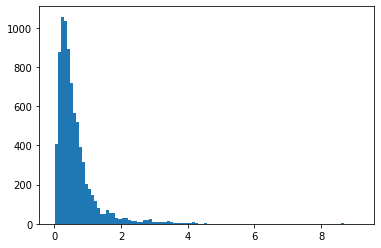

In [192]:
# check histogram of distances
g = plt.hist(station_distance, bins=100)

## User mean sentiment

In [205]:
with open("mean_user_sentiment.pkl", "rb") as f:
    df_mean_user_sentiment = pickle.load(f)

In [216]:
df_listings = pd.merge(df_listings, df_mean_user_sentiment, left_on="id", right_on="listing_id", how='left')

print("mean sentiment score of listing is :", df_listings[~df_listings.sentiment.isnull()].sentiment.mean() )

# Output listing dataframe

In [223]:
# with open("listings.pkl", "wb") as f:
#     pickle.dump(df_listings, f)